In [ ]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt


# Analyze the WFP mVAM FCS data (district level, 2020-2021.5) from Martini et al. (2024)
Our goal here is to investigate the infrannual FCS dynamics via statistics 
1) subset Sub-Saharan Africa in the data
2) analyze each timeseries: generate a statistical summary including mean, coeff. of var., and power spectrum peak

In [ ]:
#
#part 1
#
sub_saharan_africa_list = [
    'Angola',
    'Benin',
    'Botswana',
    'Burkina Faso',
    'Burundi',
    'Cabo Verde', # Note: Your list has 'Cape Verde'
    'Cape Verde', # Include the name as it appears in your list
    'Cameroon',
    'Central African Republic',
    'Chad',
    'Comoros',
    'Congo', # Refers to the Republic of the Congo
    'Democratic Republic of the Congo',
    "Côte d'Ivoire",
    'Djibouti',
    'Equatorial Guinea',
    'Eritrea',
    'Eswatini',
    'Ethiopia',
    'Gabon',
    'Gambia',
    'Ghana',
    'Guinea',
    'Guinea-Bissau',
    'Kenya',
    'Lesotho',
    'Liberia',
    'Madagascar',
    'Malawi',
    'Mali',
    'Mauritania',
    'Mauritius',
    'Mayotte', # French overseas department, geographically included
    'Mozambique',
    'Namibia',
    'Niger',
    'Nigeria',
    'Réunion', # French overseas department, geographically included
    'Rwanda',
    'Saint Helena', # British Overseas Territory, geographically included
    'Sao Tome and Principe',
    'Senegal',
    'Seychelles',
    'Sierra Leone',
    'Somalia',
    'South Africa',
    'South Sudan',
    'Sudan', # Often included, though sometimes grouped with North Africa
    'Swaziland', # Older name for Eswatini, present in your list
    'Togo',
    'Uganda',
    'United Republic of Tanzania', # Matches the name in your list
    'Zambia',
    'Zimbabwe'
]
import numpy as np
# 3. Perform the 'isin' check
is_in_ssa = np.isin('Zambia', sub_saharan_africa_list)


In [3]:
admin_paths = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\nowcasting_food_insecurity_data_and_code_rebuttal_2\database\data\first_level_admin_area_codes.csv")
nowcasting_data = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\nowcasting_food_insecurity_data_and_code_rebuttal_2\database\data\train_val_test_dataset.csv")

In [228]:
# Filter admin_paths to include only SSA countries
ssa_admin_paths = admin_paths[admin_paths['adm0_name'].isin(sub_saharan_africa_list)]

# Filter nowcasting_data to include only SSA countries based on adm1_code
ssa_nowcasting_data = nowcasting_data[nowcasting_data['adm1_code'].isin(ssa_admin_paths['adm1_code'])]

# Calculate data lengths for SSA countries
ssa_data_lengths = [len(ssa_nowcasting_data[ssa_nowcasting_data.adm1_code == code]) for code in ssa_nowcasting_data["adm1_code"].unique()]

In [6]:
# Create a dictionary with (adm1_name, adm0_name) as keys and data lengths as values
ssa_data_lengths_dict = {
    (adm1, adm0): length
    for (adm1, adm0), length in zip(
        zip(ssa_admin_paths['adm1_name'], ssa_admin_paths['adm0_name']),
        ssa_data_lengths
    )
}

# Display the dictionary
ssa_data_lengths_dict

{('Bafata', 'Guinea-Bissau'): 4,
 ('Biombo', 'Guinea-Bissau'): 3,
 ('Bolama', 'Guinea-Bissau'): 5,
 ('Cacheu', 'Guinea-Bissau'): 5,
 ('Gabu', 'Guinea-Bissau'): 3,
 ('Oio', 'Guinea-Bissau'): 5,
 ('Quinara', 'Guinea-Bissau'): 3,
 ('Sector Autonomo De Bissau', 'Guinea-Bissau'): 3,
 ('Tombali', 'Guinea-Bissau'): 3,
 ('Boke', 'Guinea'): 2,
 ('Conakry', 'Guinea'): 18,
 ('Faranah', 'Guinea'): 19,
 ('Kankan', 'Guinea'): 1,
 ('Kindia', 'Guinea'): 6,
 ('Labe', 'Guinea'): 6,
 ('Mamou', 'Guinea'): 4,
 ('Nzerekore', 'Guinea'): 2,
 ('Central', 'Kenya'): 2,
 ('Coast', 'Kenya'): 2,
 ('Eastern', 'Kenya'): 6,
 ('Nairobi', 'Kenya'): 6,
 ('North Eastern', 'Kenya'): 2,
 ('Nyanza', 'Kenya'): 2,
 ('Rift Valley', 'Kenya'): 2,
 ('Western', 'Kenya'): 2,
 ('Berea', 'Lesotho'): 71,
 ('Butha Buthe', 'Lesotho'): 2,
 ('Leribe', 'Lesotho'): 69,
 ('Mafeteng', 'Lesotho'): 67,
 ('Maseru', 'Lesotho'): 203,
 ("Mohale's Hoek", 'Lesotho'): 211,
 ('Mokhotlong', 'Lesotho'): 207,
 ("Qacha's Nek", 'Lesotho'): 209,
 ('Quthing', 

In [231]:
@pd.api.extensions.register_series_accessor("normalize")
class NormalizeAccessor:
    def __init__(self, series):
        self._series = series

    def __call__(self):
        return (self._series - self._series.min()) / (self._series.max() - self._series.min())


C:\Users\danie\AppData\Local\Temp\ipykernel_117792\3262182652.py:2: UserWarning: registration of accessor <class '__main__.NormalizeAccessor'> under name 'normalize' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  class NormalizeAccessor:


## part 2: Analyze Data

In [232]:
import numpy as np
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt

def fourier_uneven(time_vector,signal):
    """
    Perform Fourier analysis on unevenly spaced time series data.
    
    Parameters:
    - time_vector: array-like, time points of the observations
    - signal: array-like, observed values at the time points
    
    Returns:
    - frequency: array of frequencies
    - power: array of power spectral density values
    """
    time_vector = time_vector[np.isfinite(signal)]
    signal = signal[np.isfinite(signal)]
    # Ensure time_vector and signal are numpy arrays and time is numeric
    # Convert datetime to days since the first observation
    time_days = (time_vector - time_vector.min()).dt.total_seconds() / (24 * 3600)
    
    # Perform Lomb-Scargle periodogram analysis
    frequency, power = LombScargle(time_days, signal).autopower(nyquist_factor=5, samples_per_peak=10)
    t = time_days.values
    
    # 2. Compare against white noise null hypothesis
    # Calculate False Alarm Probability (FAP) levels
    # FAP = probability that at least one peak is as high as observed *if* the data were pure noise

    # Find the highest peak
    best_frequency = frequency[np.argmax(power)]
    peak_power = np.max(power)
    peak_period = 1. / best_frequency

    #print(f"Highest peak power: {peak_power:.4f} at frequency {best_frequency:.4f} (period: {peak_period:.2f} days)")

    # Calculate FAP of the highest peak
    fap_peak = LombScargle(t, signal).false_alarm_probability(peak_power)
    if fap_peak < 0.05:
        period = peak_period
    else:
        period = np.nan
    return period
# Ensure time_vector and signal are numpy arrays and time is numeric
# Convert datetime to days since the first observation
time_vector = kigoma_data["date"][kigoma_data["date"]>= "2020-01-01"]
time_days = (time_vector - time_vector.min()).dt.total_seconds() / (24 * 3600)
t = time_days.values
y = kigoma_data.set_index('date')["fcs"].rolling(window='30d', min_periods=1).mean().values[kigoma_data["date"]>= "2020-01-01"] # Assuming 'signal' is the corresponding time series numpy array

# 1. Compute Lomb-Scargle Periodogram
# Define frequency grid (optional, LombScargle can determine automatically)
# nyquist_factor determines how high a frequency to search, relative to the average sampling
# samples_per_peak determines the frequency resolution
frequency, power = LombScargle(t, y).autopower(nyquist_factor=5, samples_per_peak=10)

# 2. Compare against white noise null hypothesis
# Calculate False Alarm Probability (FAP) levels
# FAP = probability that at least one peak is as high as observed *if* the data were pure noise
fap_levels = [0.1, 0.05, 0.01] # Significance levels (e.g., 10%, 5%, 1%)
fap_power = LombScargle(t, y).false_alarm_level(fap_levels)

# Find the highest peak
best_frequency = frequency[np.argmax(power)]
peak_power = np.max(power)
peak_period = 1. / best_frequency

print(f"Highest peak power: {peak_power:.4f} at frequency {best_frequency:.4f} (period: {peak_period:.2f} days)")

# Calculate FAP of the highest peak
fap_peak = LombScargle(t, y).false_alarm_probability(peak_power)
print(f"False Alarm Probability (FAP) of the highest peak: {fap_peak:.4e}")
if fap_peak < 0.05:
    print("The highest peak is statistically significant (p < 0.05) compared to white noise.")
else:
    print("The highest peak is not statistically significant (p >= 0.05) compared to white noise.")

# Plot the periodogram
plt.figure(figsize=(12, 6))
plt.plot(frequency, power, label='Lomb-Scargle Periodogram')

# Plot FAP levels
colors = ['lightgray', 'silver', 'darkgray']
for i, level in enumerate(fap_levels):
    plt.axhline(fap_power[i], linestyle='--', color=colors[i], label=f'FAP {level*100:.0f}% ({fap_power[i]:.2f})')

plt.xlabel('Frequency (1/day)')
plt.ylabel('Lomb-Scargle Power')
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.grid(True, alpha=0.5)
# Optional: Zoom in on lower frequencies if peaks are there
# plt.xlim(0, 0.1) # Example limit
plt.show()

# Plot vs Period instead of Frequency
plt.figure(figsize=(12, 6))
periods = 1. / frequency
# Sort by period for plotting
sort_idx = np.argsort(periods)
plt.plot(periods[sort_idx], power[sort_idx], label='Lomb-Scargle Periodogram')

# Plot FAP levels
for i, level in enumerate(fap_levels):
    plt.axhline(fap_power[i], linestyle='--', color=colors[i], label=f'FAP {level*100:.0f}% ({fap_power[i]:.2f})')

plt.xlabel('Period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.title('Lomb-Scargle Periodogram (vs Period)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.xscale('log') # Periods often span orders of magnitude
# Optional: Set x-axis limits for periods of interest
# plt.xlim(10, 1000) # Example limit
plt.show()

ValueError: zero-size array to reduction operation maximum which has no identity

In [240]:
ssa_admin_paths[ssa_admin_paths["adm0_name"]=="Ethiopia"].adm1_name.values

array(['Addis Ababa', 'Afar', 'Amhara', 'Beneshangul Gumu', 'Dire Dawa',
       'Gambela', 'Hareri', 'SNNPR', 'Tigray', 'Oromia', 'Somali',
       'Addis Ababa', 'Afar', 'Amhara', 'B. Gumuz', 'Dire Dawa',
       'Gambela', 'Harari', 'Oromia', 'SNNPR', 'Somali', 'Tigray'],
      dtype=object)

In [267]:
ssa_admin_paths["adm0_name"].unique()

array(['Guinea-Bissau', 'Guinea', 'Kenya', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius',
       'Mayotte', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Réunion', 'Saint Helena', 'Sao Tome and Principe', 'Senegal',
       'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa',
       'Swaziland', 'Eswatini', 'Togo', 'Uganda',
       'United Republic of Tanzania', 'Zambia', 'Zimbabwe', 'Benin',
       'Botswana', 'Sudan', 'Burkina Faso', 'Burundi', 'Cameroon',
       'Cape Verde', 'Central African Republic', 'Chad', 'Comoros',
       'Congo', "Côte d'Ivoire", 'Democratic Republic of the Congo',
       'Djibouti', 'South Sudan', 'Equatorial Guinea', 'Eritrea',
       'Ethiopia', 'Angola', 'Gabon', 'Gambia', 'Ghana'], dtype=object)

In [275]:
ssa_admin_paths[ssa_admin_paths["adm1_name"] == district]["adm1_code"].iloc[0]


415

            date  adm1_code       fcs      rcsi is_historical  \
39735 2020-12-22        408       NaN  0.466999           NaN   
39812 2020-12-22        408  0.157995       NaN           NaN   
40064 2020-12-24        408       NaN  0.467011           NaN   
40145 2020-12-24        408  0.156809       NaN           NaN   
40669 2020-12-28        408       NaN  0.461342           NaN   
...          ...        ...       ...       ...           ...   
70414 2021-07-09        408  0.135936       NaN           NaN   
71817 2021-07-19        408       NaN  0.469668           NaN   
71900 2021-07-19        408  0.142465       NaN           NaN   
73523 2021-07-30        408       NaN  0.459459           NaN   
73598 2021-07-30        408  0.131308       NaN           NaN   

       num_fatalities_battles_remote_violence_90days_difference  \
39735                                                0.0          
39812                                                0.0          
40064             

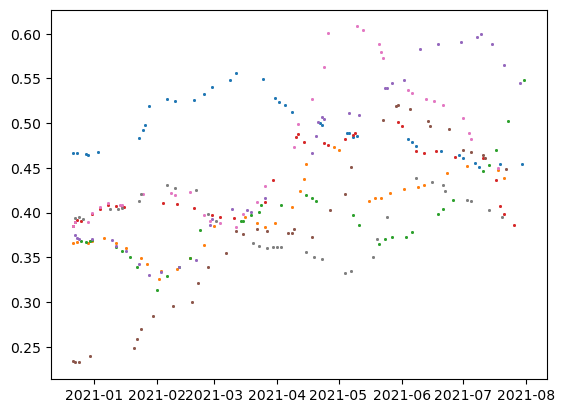

In [284]:
food_security_characteristics = {}
for nation in ssa_admin_paths["adm0_name"].unique():
    if nation == "Angola":
        fs_dict_nation = {}
        for district in ssa_admin_paths["adm1_name"][ssa_admin_paths["adm0_name"]==nation].unique()[10:]:
                #district_code = ssa_admin_paths[ssa_admin_paths["adm1_name"] == district]["adm1_code"].iloc[0]
                #
                #kigoma_data = nowcasting_data[nowcasting_data['adm1_code'] == ssa_admin_paths[ssa_admin_paths["adm1_name"] == district]["adm1_code"].iloc[0]]
                #t = kigoma_data["date"][kigoma_data["date"]>= "2020-01-01"]
                #y = kigoma_data.set_index('date')["rcsi"].rolling(window='30d', min_periods=1).mean().values[kigoma_data["date"]>= "2020-01-01"]
                try: 
                    #print(y)
                    kigoma_data = nowcasting_data[nowcasting_data['adm1_code'] == ssa_admin_paths[ssa_admin_paths["adm1_name"] == district]["adm1_code"].iloc[0]]        
                    district_code = ssa_admin_paths[ssa_admin_paths["adm1_name"] == district]["adm1_code"].iloc[0]
                    print(kigoma_data)
                    if len(kigoma_data) != 0:
                        t = kigoma_data["date"][kigoma_data["date"]>= "2020-01-01"]
                        y = kigoma_data.set_index('date')["rcsi"].rolling(window='30d', min_periods=1).mean().values[kigoma_data["date"]>= "2020-01-01"]
                        fs_dict_nation[district]={'period':fourier_uneven(t,y),'mean':y.mean(),'cv':y.std()/y.mean()}
                    else:
                        fs_dict_nation[district]={'period':np.nan,'mean':np.nan,'cv':np.nan}
                    plt.scatter(t,y,s=1)
                except:
                    pass
                #district_code = ssa_admin_paths[ssa_admin_paths["adm1_name"] == district]["adm1_code"].iloc[0]
                try:
                    fs_dict_nation[district]={'period':fourier_uneven(t,y),'mean':np.nanmean(y),'cv':np.nanstd(y)/np.nanmean(y)}
                except: 
                    fs_dict_nation[district]={'period':np.nan,'mean':np.nan,'cv':np.nan}
                #plt.scatter(pd.to_datetime(kigoma_data["date"]),kigoma_data["rcsi"].rolling(window=8, min_periods=1).mean().normalize(),s=1)
                #plt.scatter(t,y,s=1,label=district)
                #plt.scatter(pd.to_datetime(kigoma_data["date"]),kigoma_data["fcs"],s=1) #checking that not spurious oscillation from slutsky-yule
                #plt.xlim(pd.to_datetime("2020-01-01"), pd.to_datetime("2023-10-01")) 
                # Display the filtered data
                #kigoma_data
                #plt.legend()
        food_security_characteristics[nation] = fs_dict_nation

In [254]:
#
#. Save the resulting dictionary of food security characteristics
#  to a .json file
#
import json

# Define the file path where you want to save the dictionary
file_path = '../Data/nowcasting_food_insecurity_data_and_code_rebuttal_2/fs_timeseries_stats/food_security_characteristics.json'

# Save the dictionary to a JSON file
try:
    with open(file_path, 'w') as f:
        # Use json.dump to write the dictionary to the file
        # indent=4 makes the output file human-readable
        json.dump(food_security_characteristics, f, indent=4)
    print(f"Dictionary successfully saved to {file_path}")
except Exception as e:
    print(f"An error occurred while saving the dictionary: {e}")

# Optional: Load the dictionary back from the file to verify
try:
    with open(file_path, 'r') as f:
                  loaded_dict = json.load(f)
    print("\nDictionary loaded back from file (first few items):")
    print({k: loaded_dict[k] for k in list(loaded_dict)[:2]}) # Print first 2 nations for brevity
except Exception as e:
     print(f"An error occurred while loading the dictionary back: {e}")

Dictionary successfully saved to ../Data/nowcasting_food_insecurity_data_and_code_rebuttal_2/fs_timeseries_stats/food_security_characteristics.json

Dictionary loaded back from file (first few items):
{'Guinea-Bissau': {'Bafata': {'period': nan, 'mean': nan, 'cv': nan}, 'Biombo': {'period': nan, 'mean': nan, 'cv': nan}, 'Bolama': {'period': nan, 'mean': nan, 'cv': nan}, 'Cacheu': {'period': nan, 'mean': nan, 'cv': nan}, 'Gabu': {'period': nan, 'mean': nan, 'cv': nan}, 'Oio': {'period': nan, 'mean': nan, 'cv': nan}, 'Quinara': {'period': nan, 'mean': nan, 'cv': nan}, 'Sector Autonomo De Bissau': {'period': nan, 'mean': nan, 'cv': nan}, 'Tombali': {'period': nan, 'mean': nan, 'cv': nan}}, 'Guinea': {'Boke': {'period': 4820.0, 'mean': 0.31238443833039387, 'cv': 0.300487897695905}, 'Conakry': {'period': 211.30434782608694, 'mean': 0.3801223562152133, 'cv': 0.18582653084356965}, 'Faranah': {'period': 213.04347826086956, 'mean': 0.5210708243557423, 'cv': 0.13083629405939587}, 'Kankan': {'per

In [250]:

loaded_dict 

{}

C:\Users\danie\AppData\Local\Temp\ipykernel_117792\4002046698.py:13: RuntimeWarning: invalid value encountered in less
  labels[flat_fs < np.nanquantile(flat_fs,0.2)] = 0
C:\Users\danie\AppData\Local\Temp\ipykernel_117792\4002046698.py:14: RuntimeWarning: invalid value encountered in greater
  labels[flat_fs > np.nanquantile(flat_fs,0.8)] = 2


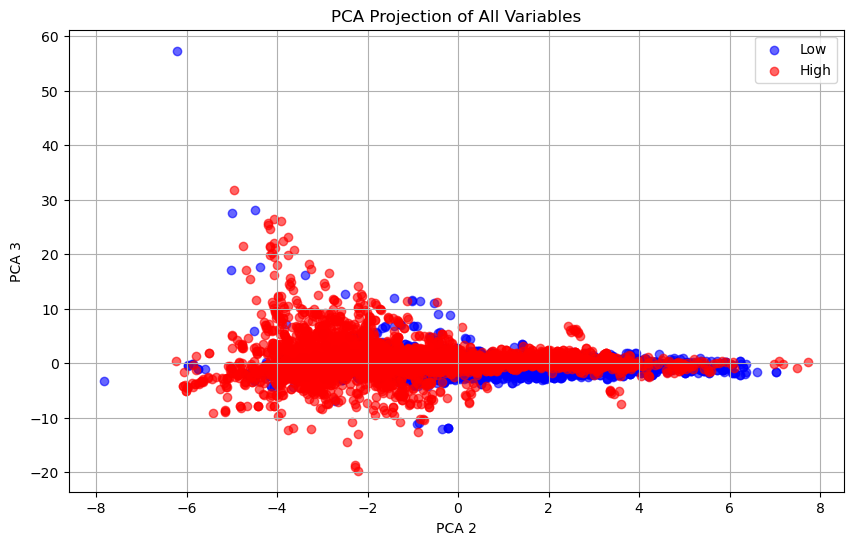

In [213]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 

# Reshape as before
reshaped_data = nowcasting_data.values[:,5:38]
flat_fs = nowcasting_data.values[:,2]

# Label encoding: 0 = low, 1 = normal, 2 = high
labels = np.full(flat_fs.shape, 1)
labels[flat_fs < np.nanquantile(flat_fs,0.2)] = 0
labels[flat_fs > np.nanquantile(flat_fs,0.8)] = 2

# Impute & scale
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(reshaped_data)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

# PCA projection
pca = PCA(n_components=3)
proj = pca.fit_transform(data_scaled)

# Plot
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
names = ['Low', 'Normal', 'High']
for i in [0,2]:
    mask = labels == i
    plt.scatter(proj[mask, 0], proj[mask, 1], alpha=0.6, color=colors[i], label=names[i])
plt.title("PCA Projection of All Variables")
plt.xlabel("PCA 2")
plt.ylabel("PCA 3")
plt.legend()
plt.grid(True)
plt.show()


In [65]:
import plotly.express as px
import plotly.graph_objects as go # Optional: for more customization if needed

# --- Create a Pandas DataFrame for Plotly ---
# Plotly works well with DataFrames
df_pca = pd.DataFrame(proj, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca['Category'] = labels # Add the string labels as a column

# --- Interactive 3D Plotting with Plotly ---

# Define a color map for the categories
color_map = {'Low': 'blue', 'Normal': 'green', 'High': 'red'}

# Create the interactive 3D scatter plot
fig = px.scatter_3d(df_pca,
                    x='PCA1',
                    y='PCA2',
                    z='PCA3',
                    color='Category', # Color points based on the 'Category' column
                    color_discrete_map=color_map, # Apply the defined colors
                    title="Interactive 3D PCA Projection",
                    labels={'PCA1': 'PCA Component 1', # Rename axes for clarity
                            'PCA2': 'PCA Component 2',
                            'PCA3': 'PCA Component 3'},
                    hover_data={'Category': True} # Show category name on hover
                   )
fig.update_traces(marker_size=.5) # You can adjust the value '3' as needed

# Optional: Customize layout further (e.g., figure size)
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=40) # Adjust margins
    # You can add more layout customizations here
)

# Display the plot (this will open in a browser or display in a compatible environment like Jupyter)
fig.show()


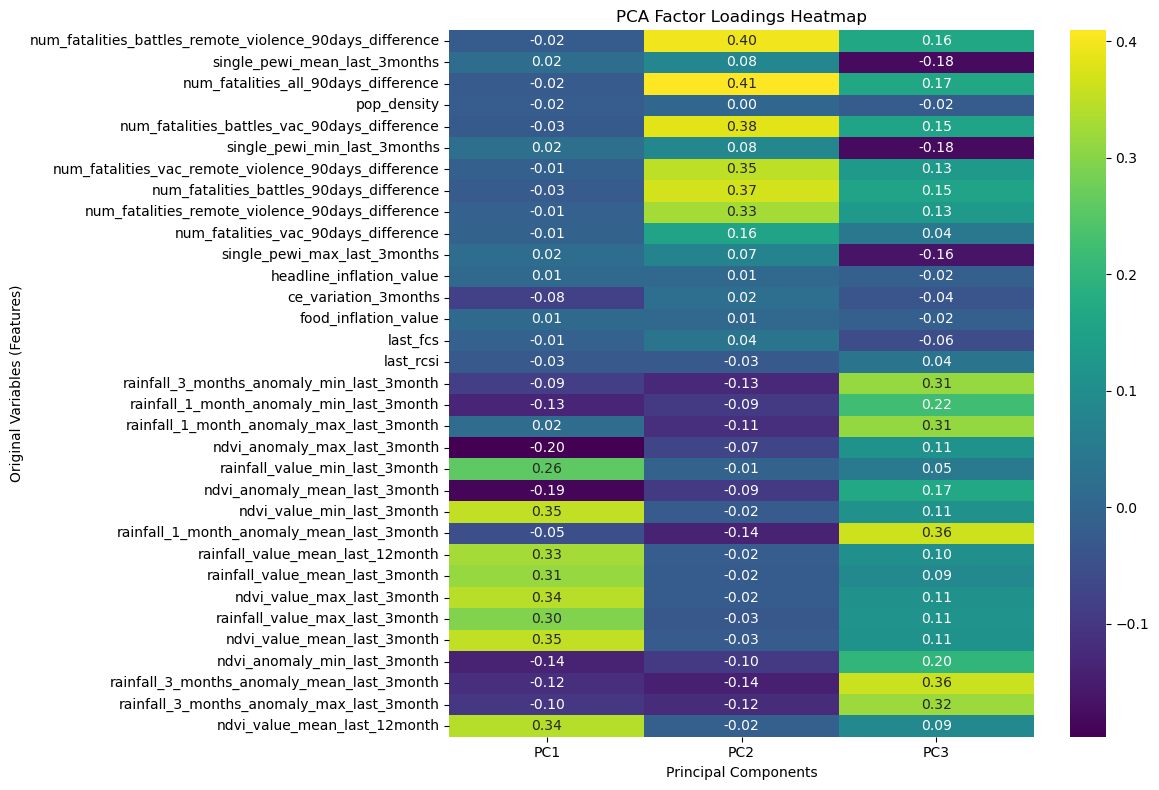

In [34]:

# The loadings are stored in pca.components_
# Shape: (n_components, n_features)
loadings = pca.components_

# Create feature names for better readability
# These names represent 'OriginalFeature_Timepoint'
feature_names =  nowcasting_data.columns[5:38]
# Make sure the order matches the reshape operation above! Check `data_for_pca` creation.
# If using `reshape(..., -1)`, the order is usually the last index changing fastest.
# If your original shape was (samples, timepoints, features), reshape(samples, -1) order is like:
# F1T1, F1T2, ..., F1Tn, F2T1, F2T2, ..., F2Tn, ...
# Let's adjust the feature name generation assuming (samples, timepoints, features) input
#feature_names = [f'Feat{f}_Time{t}' for f in range(num_features_orig) for t in range(num_timepoints)]
# If your original data was (samples, features, timepoints), the order would be different. Double-check!
# Assuming (samples, timepoints, features) -> reshape(samples, -1) gives:
# T1F1, T1F2, ... T1Fn, T2F1, T2F2, ... T2Fn, ...
# feature_names = [f'Feat{f}_Time{t}' for t in range(num_timepoints) for f in range(num_features_orig)]
# Choose the one that matches your data_timeseries structure and reshape order. Let's stick with the first one.


# Create a DataFrame for easy viewing
# Rows: Principal Components, Columns: Original Variables (Features)
# Transpose loadings so original features are rows and PCs are columns
loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2','PC3'], index=feature_names)

# You might also want to visualize the loadings, e.g., with a heatmap
import seaborn as sns

plt.figure(figsize=(12, 8)) # Adjust size as needed
sns.heatmap(loadings_df, cmap='viridis', annot=True, fmt='.2f')
plt.title('PCA Factor Loadings Heatmap')
plt.xlabel('Principal Components')
plt.ylabel('Original Variables (Features)')
plt.tight_layout() # Adjust layout
plt.show()